<!-- # CNN autoencoder and Clustering from MTRX data

Use this notebook to load Scienta Omicron Matrix format SPM data and create standardised images for machine learning training and analysis. The code can generate both JPG image data, useful for manually checking the data, and windowed numpy data that can be loaded into ML models. 

The notebook then creates an autoencoder for training on a large dataset, followed by KMEANS clustering. 

**Author**: Steven R. Schofield  
**Created**: November, 2024 -->

# Machine learning autoencoder + Kmeans for STM image data analysis
## Steven R. Schofield (Universtiy College London) Dec. 2024.

### Load required modules

In [1]:
# Define path where to find the module. This allows for a different path depending on where the code is running (my mac or the cluster)
import os
import sys

# Define candidate paths
module_path_list = [
    '/Users/steven/academic-iCloud/Python/modules',
    '/hpc/aklicka/Python/modules'
]

data_path_list = [
    '/Users/steven/Python-data',
    '/hpc/aklicka/Python-data/training-set-1'
]

# Resolve actual paths
module_path = next((p for p in module_path_list if os.path.exists(p)), None)
data_path = next((p for p in data_path_list if os.path.exists(p)), None)

# Check and report missing paths
if module_path is None:
    print("Error: Could not locate a valid module path.")
if data_path is None:
    print("Error: Could not locate a valid data path.")

if module_path is None or data_path is None:
    sys.exit(1)

# Print resolved paths
print(f"module_path = {module_path}")
print(f"data_path = {data_path}")

# Reduce TensorFlow verbosity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


module_path = /hpc/aklicka/Python/modules
data_path = /hpc/aklicka/Python-data/training-set-1


In [2]:
# # Ensure modules are reloaded 
%load_ext autoreload
%autoreload 2

# Import standard modules
import numpy as np

import platform

from datetime import datetime

# Add custom module path to list
sys.path.append(module_path)

# Import custom module
import SRSML24.data_prep as dp
import SRSML24.model as m
import SRSML24.utils as ut

import tensorflow as tf
#from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import pandas as pd
from IPython.display import display, Markdown

import skimage as ski
import skimage.morphology as morphology
import skimage
from skimage import morphology, measure

#import platform 

m.print_system_info()

start_time = dp.current_datetime()


Python version: 3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]
TensorFlow version: 2.4.1
TensorFlow is built with CUDA: True
TensorFlow is built with ROCm: False

System: Linux 4.18.0-553.22.1.el8_10.x86_64 (x86_64)
Platform: Linux-4.18.0-553.22.1.el8_10.x86_64-x86_64-with-glibc2.28
Processor: x86_64

Number of GPUs available to TensorFlow: 1
GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

>>> Running with GPU available <<<  (Linux-4.18.0-553.22.1.el8_10.x86_64-x86_64-with-glibc2.28)

Current time 2025-06-17 13:40:40


### Programme variable setup

In [10]:
# Parameters for windows creation
# General
job_name = 'June_25_BIG_model'
verbose = False             # Set this True to print out more information

# MTRX preprocessing
flatten_method = 'poly_xy'
pixel_density = 15.0        # Convert all images to a constant pixel density
pixel_ratio = 0.7           # If an image has less than this % in the slow scan direction it is discarded
data_scaling = 1.e9         # Scale the z-height of the data

# Windowing
window_size = 32            # Window size for training/validation
window_pitch = 8            # Window pitch for training/validation

# Data saving options
save_windows = True         # Save the windows as numpy files
together = True             # Set this True to save image windows for a mtrx image as a single file rather than separate files.
save_jpg = False            # Save the full image as a jpg
collate = False             # Set this True to remove all subfolder directories and save all data in root data path
save_window_jpgs = False    # Save the windows as jpgs for inspection

# Parameters for training
model_name = 'unet_' + job_name
batch_size = 128
buffer_size = 12800 # shuffling
learning_rate = 1e-4
epochs = 5

# Parameters for clustering
cluster_model_name = model_name + '_kmeans'
cluster_batch_size = 5120 # This is the number of latent features in a batch for clustering. 
                          # Does not have to be the same as for training and probably should 
                          # be larger. 
cluster_buffer_size = cluster_batch_size * 5    # shuffling buffer
num_clusters=20                                 # Desired number of clusters (centroids) to form in the data.
max_iter=1000                                   # Maximum iterations allowed for each mini-batch to refine centroids.
reassignment_ratio=0.05                         # Fraction of clusters reassigned per step; lower values stabilize updates.

# Parameters for PREDICTIONS
predict_window_pitch = 2                        # Window pitch for prediction
predictions_batch_size = 2**15                  # Batch size for predictions


# DATA LIMITS FOR TESTING THE CODE
mtrx_train_data_limit = None                    # Number of MTRX files to process (training)
mtrx_test_data_limit = None                     # Number of MTRX files to process (validation)

train_data_limit = 200                         # Limit the data used in the autoencoder training
test_data_limit = 50                          # Limit the data used in the autoencoder training (validation)

In [4]:

job_data_path = dp.create_new_data_path(data_path, job_name, include_date=False)

mtrx_train_path = os.path.join(data_path, 'mtrx/train')
mtrx_test_path = os.path.join(data_path, 'mtrx/test')
mtrx_predict_path = os.path.join(data_path, 'mtrx/predict')

model_path = os.path.join(job_data_path,'model')
cluster_model_path = os.path.join(job_data_path,'cluster_model')

latent_features_path = os.path.join(job_data_path, 'latent_features')
predict_latent_features_path = os.path.join(job_data_path, 'latent_features_predictions')

windows_train_path = os.path.join(job_data_path, 'windows/train')
windows_test_path = os.path.join(job_data_path, 'windows/test')
windows_predict_path = os.path.join(job_data_path, 'windows/predict')

predictions_path = os.path.join(job_data_path, f'predictions')

train_feature_windows_path = os.path.join(job_data_path, 'feature_windows/train')
predict_feature_windows_path = os.path.join(job_data_path, 'feature_windows/predict')
train_feature_windows_latent_path = os.path.join(job_data_path, 'feature_windows_latent/train')
predict_feature_windows_latent_path = os.path.join(job_data_path, 'feature_windows_latent/predict')
feature_predictions_path = os.path.join(job_data_path, 'feature_predictions')

cluster_model_feature_windows_path = os.path.join(job_data_path, 'cluster_model_feature_windows')

### Process Matrix format data to windows for autoencoder training and validation

In [ ]:
# REMOVE ALL DATA FOLDERS EXCEPT MTRX 
dp.delete_data_folders(job_data_path, subdirectories=["jpg", "windows", "windows-jpg"], override=True)

In [ ]:
# Training data
mtrx_train_file_list, _ = dp.list_files_by_extension(mtrx_train_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_train_file_list[0:mtrx_train_data_limit],
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, window_pitch = window_pitch,
    save_windows = save_windows,
    save_window_jpgs=save_window_jpgs,
    save_jpg = save_jpg,
    together = together,
    collate = collate,
    verbose = verbose
    )

# Test data
mtrx_test_file_list, _ = dp.list_files_by_extension(mtrx_test_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_test_file_list[0:mtrx_test_data_limit],
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, window_pitch = window_pitch,
    save_windows = save_windows,
    save_window_jpgs=save_window_jpgs,
    save_jpg = save_jpg,
    together = together,
    collate = collate,
    verbose = verbose
    )

### Build tensorflow data pipeline for training and validation of autoencoder

In [ ]:
# Training data - tensorflow data pipeline for autoencoder
train_files, num_train = dp.list_files_by_extension(windows_train_path, 'npy')
train_files = train_files[:train_data_limit]

# Create dataset with prefetching
train_dataset = m.create_tf_dataset_batched(
    train_files, 
    batch_size=batch_size, 
    buffer_size=buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

# Validation data - tensorflow data pipeline for autoencoder
test_files, num_test = dp.list_files_by_extension(windows_test_path, 'npy')
test_files = test_files[:test_data_limit]

# Create dataset with prefetching
test_dataset = m.create_tf_dataset_batched(
    test_files, 
    batch_size=batch_size, 
    buffer_size=buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

In [ ]:
# Display the first 16 images in a 4x4 grid along with their labels
def display_images_with_labels(images, labels, num_images=16):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

num_images = 64
offset = 0
# show one image with specific index from train_dataset
for i, (x, y) in enumerate(train_dataset):
    if i == 52:  # Show only the first batch
        print(f"Batch {i}:")
        print(f"x shape: {x.shape}, y shape: {y.shape}")
        plt.figure(figsize=(20, 20))
        for index in range(num_images):
            plt.subplot(8, 8, index + 1)
            plt.imshow(x[index + offset].numpy().squeeze(), cmap='viridis')
            #plt.title(f'Label: {labels[index+offset]}')
            plt.axis('off')
        
        plt.show()
        break
    


In [ ]:
# Build and compile the UNET model
autoencoder_model = m.build_autoencoder(window_size=window_size,model_name=model_name)
autoencoder_model.summary()
m.save_model_summary(autoencoder_model, model_path, model_name=model_name)

# Can also save a graphical representation of the model
# This requires pydot and graphviz to be installed
# pip install pydot
# pip install graphviz
# If you are using a Mac, you may need to install graphviz using brew
# brew install graphviz
m.save_model_diagram(autoencoder_model, model_path, model_name=model_name, show_shapes=False, show_layer_names=False, expand_nested=False)

# Check if running on Apple Silicon
is_mac_silicon = platform.system() == "Darwin" and platform.processor() == "arm"

if is_mac_silicon:
    print("Detected Mac with Apple Silicon. Compiling the model with the legacy RMSprop optimizer for compatibility with TensorFlow-metal.")
    autoencoder_model.compile(
        optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mse', 'mae']
    )
else:
    print("Compiling the model with the RMSprop optimizer.")
    autoencoder_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mse', 'mae']
    )



### Train autoencoder

In [ ]:
# Train the model using the tf.data datasets
history = autoencoder_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1
)
model_train_time = datetime.now().strftime('%Y%m%d_%H%M%S')
print(f"Model training completed at {model_train_time}")

# Save the model as soon as training completes
m.save_model(autoencoder_model, model_path, model_name=model_name, model_train_time=model_train_time)

end_time = dp.current_datetime()
dp.elapsed_time(start_time,end_time)

### Extract Latent Features

In [ ]:
dp.delete_data_folders(
    job_data_path, 
    subdirectories='latent_features',
    override=True)

In [ ]:
# Load the trained autoencoder model
autoencoder_model = m.load_model(model_path, model_name=model_name)

In [ ]:
# Training data - tensorflow data pipeline 
train_files, num_train = dp.list_files_by_extension(windows_train_path, 'npy')
train_files = train_files[:train_data_limit]

train_dataset = m.create_tf_dataset_batched(
    train_files, 
    batch_size=cluster_batch_size, 
    buffer_size=cluster_buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

In [ ]:
m.extract_latent_features_to_disk_from_prebatched_windows(
    autoencoder_model, 
    train_dataset, 
    latent_features_path, 
    bottleneck_layer_name='bottleneck',
    features_name='latent_features_train',
    return_array=False,
    verbose=False)

### Train KMEANS using latent features saved to disk

In [ ]:
# List and sort latent feature files
latent_features_files, num_latent_files = dp.list_files_by_extension(latent_features_path, 'npy')

In [ ]:
# Load the latent features from disk into a tensor dataset pipeline
latent_features_dataset = m.create_latent_features_tf_dataset(
    latent_features_files,
    batch_size=cluster_batch_size,
    shuffle=True, 
    shuffle_buffer_size=cluster_buffer_size)

In [ ]:

cluster_model, convergence_history = m.train_kmeans(
    latent_features_dataset,                # tf.data.Dataset containing batches of latent feature vectors.
    batch_size=cluster_batch_size,          # Size of each batch for the KMeans model (controls memory usage and stability).
    num_clusters=num_clusters,              # Desired number of clusters (centroids) to form in the data.
    max_iter=5000000,                      # Maximum iterations allowed for each mini-batch to refine centroids.
    reassignment_ratio=0.01   # Fraction of clusters reassigned per step; lower values stabilize updates.
)
# Save and plot convergence history
m.plot_kmeans_convergence(convergence_history, cluster_model_path, model_name=cluster_model_name)

# Save cluster model
m.save_cluster_model(cluster_model, cluster_model_path, model_name=cluster_model_name)

### Process Matrix format data to windows for making predictions 

In [ ]:
dp.delete_data_folders(
    job_data_path, 
    subdirectories=['windows/predict','windows-jpg/predict','jpg/predict'],
    override=True)

In [ ]:
# Prediction data in MTRX format
mtrx_predict_file_list, _ = dp.list_files_by_extension(mtrx_predict_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_predict_file_list,
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, 
    window_pitch = predict_window_pitch,
    save_windows = save_windows,
    save_window_jpgs=save_window_jpgs,
    save_jpg = save_jpg,
    together = together,
    collate = collate,
    verbose = verbose
)

### Make predictions using the trained autoencoder and KMEANS models

In [5]:
# Load the trained autoencoder
autoencoder_model = m.load_model(model_path, model_name=model_name)

# Load a previously saved cluster model from disk
cluster_model = m.load_cluster_model(cluster_model_path, model_name=cluster_model_name)

Model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/model/unet_June_25_BIG_model.keras
Cluster model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/cluster_model/unet_June_25_BIG_model_kmeans.pkl


In [11]:
# Training data - tensorflow data pipeline 
train_files, num_train = dp.list_files_by_extension(windows_train_path, 'npy')
train_files = train_files[:train_data_limit]

# Get the corresponding image coordimages list file
train_windows_coordinates_file_list , _ = dp.list_files_by_extension(windows_train_path,'.txt',verbose=False)
train_windows_coordinates_file_list = [
    name for name in train_windows_coordinates_file_list 
    if "coordinates" in name
]


Found 728 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/train
Found 1456 files with extension '.txt' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/train


In [13]:
ut.summarize_parameters(['job_name', 'flatten_method', 'pixel_density', 'pixel_ratio', 'data_scaling', 'window_size', 
                      'window_pitch', 'model_name', 'model_train_time', 'batch_size', 'buffer_size', 'learning_rate', 
                      'epochs', 'cluster_model_name', 'cluster_batch_size', 'cluster_buffer_size', 'num_clusters', 
                      'max_iter', 'reassignment_ratio', 'predict_window_pitch', 'mtrx_train_data_limit', 
                      'mtrx_test_data_limit', 'train_data_limit', 'test_data_limit',], save_path=predictions_path)


Saved parameter summary to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/predictions/parameter_summary_20250617_134345.csv


Parameter                          Value
0                job_name              June_25_BIG_model
1          flatten_method                        poly_xy
2           pixel_density                           15.0
3             pixel_ratio                            0.7
4            data_scaling                   1000000000.0
5             window_size                             32
6            window_pitch                              8
7              model_name         unet_June_25_BIG_model
8        model_train_time                      undefined
9              batch_size                            128
10            buffer_size                          12800
11          learning_rate                         0.0001
12                 epochs                              5
13     cluster_model_name  unet_June_25_BIG_model_kmeans
14     cluster_batch_size                           5120
15    cluster_buffer_size                          25600
16           num_clusters                             20
17               max_iter                           1000
18     reassignment_ratio                           0.05
19   predict_window_pitch                              2
20  mtrx_train_data_limit                           None
21   mtrx_test_data_limit                           None
22       train_data_limit                            200
23        test_data_limit                             50

In [ ]:

## Make predictions on the image windows and save the latent features to disk
#for prediction_file, coords_file in zip(predict_data_files_list,image_windows_coordinates_file_list):
#    # Load the windows for the image as a numpy file
#    image_windows = np.load(prediction_file)
#    # Load the image window coordinates
#    image_windows_coordinates = dp.load_coordinates_file(coords_file)
#    # Reconstruct the original image from the loaded image windows
#    reconstructed_img = dp.reconstruct_image(image_windows,image_windows_coordinates,window_size)
#    
#    # Make a tensorflow data pipeline of just the image windows for this image.
#    num_windows = image_windows.shape[0]
#    print('\n---\nProcessing file {}'.format(os.path.basename(prediction_file)))
#   
#    # Predictions windows
#    predict_dataset = m.create_tf_dataset_batched(
#        [prediction_file], 
#        batch_size=predictions_batch_size, 
#        window_size=window_size,
#        is_autoencoder=False, 
#        shuffle=False)
#   
#    # make the latent features for each window using the autoencoder model 
#    latent_predict_features, num_latent_predictions = m.extract_latent_features_to_disk_from_prebatched_windows(
#        autoencoder_model, 
#        predict_dataset, 
#        '',                 # we are not saving these predictions to disk so don't need a folder or name
#        features_name='',
#        return_array=True,
#        verbose=False)
#    
#    # make preductions 
#    cluster_predictions = cluster_model.predict(latent_predict_features)
#    
#    # Build the reconstruction of the predicted cluster label data
#    cluster_img = dp.reconstruct_cluster_image(image_windows_coordinates,window_size, cluster_predictions)
#    
#    # Pad the cluster image to the original image size
#    cluster_img = ut.padded_cluster_img = ut.pad_cluster_image(reconstructed_img,cluster_img,window_size)
#    image_name = os.path.splitext(os.path.basename(prediction_file))[0]
#  
#  #  label_stats, background_labels = m.analyse_cluster_labels(cluster_img, large_region_thresh=0.005)
#  #  cluster_img = m.relabel_background(cluster_img, background_labels)
#
#    # Save the cluster image to disk
#    m.display_reconstructed_and_cluster_images(reconstructed_img,cluster_img,
#                                                show_overlay=True,
#                                                save_to_disk=True,
#                                                output_path=predictions_path,
#                                                image_name=image_name,
#                                                dpi=150)  
#    #

In [14]:
max_size_blob = 3000 #maximum pixel area of a blob to keep in the image
area_threshold = 50 #minimum pixel area of a blob to keep in the image
feature_size = 16 #radius of feature window taken from the centroid of the blob, actual window size is 2*feature_size

In [15]:
dp.delete_data_folders(job_data_path, subdirectories=["feature_windows/train"], override=True)

for image_num in range(len(train_files)):
    prediction_file = train_files[image_num]  
    coords_file = train_windows_coordinates_file_list[image_num]  

    #get reconstructed image and cluster image
    reconstructed_img, cluster_img = m.reconstruct_predict(prediction_file, coords_file, autoencoder_model, cluster_model, window_size, predictions_batch_size)

    # Detect features and find centers
    #labeled_array, centers, num_features = m.detect_features_better(cluster_img, max_size=max_size_blob, area_threshold=area_threshold)
    features, centers, labeled_array, num_features = m.detect_features_find_centres(cluster_img, max_size=70000, area_threshold=64,)

    #extract feature windows from the reconstructed image
    feature_windows = m.extract_feature_windows(reconstructed_img, centers, px=feature_size)

    image_name = os.path.splitext(os.path.basename(prediction_file))[0]
    # Save the feature windows to disk for each reconstructed image
    dp.save_feature_windows_together(feature_windows, centers, train_feature_windows_path, base_filename=image_name, verbose=True)

    #save / display the reconstructed and cluster images with centers highlighted
    #m.display_reconstructed_and_cluster_images_and_extracted_features(reconstructed_img, cluster_img, labeled_array, centers,
    #                                                                  save_to_disk=True, output_path=feature_predictions_path, image_name=image_name, dpi=150)

Deleted: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/train
All specified folders have been successfully deleted.

---
Processing file default_2011Jan28-112629_STM-STM_Spectroscopy--14_1_FU_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (2226, 32, 32, 1)
.Combined latent features shape: (2226, 4096)
Saved 4 windows to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/train/default_2011Jan28-112629_STM-STM_Spectroscopy--14_1_FU_all_windows_all_windows.npy
Saved coordinates to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/train/default_2011Jan28-112629_STM-STM_Spectroscopy--14_1_FU_all_windows_coordinates.txt


---
Processing file default_2011Jan28-112629_STM-STM_Spectroscopy--1_1_BU_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (2650, 32, 32, 1)
.Combined laten

### Create latent vectors from feature windows

In [16]:
# Load the trained autoencoder model
autoencoder_model = m.load_model(model_path, model_name=model_name)

Model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/model/unet_June_25_BIG_model.keras


In [74]:
# Training data - tensorflow data pipeline 
train_files, num_train = dp.list_files_by_extension(train_feature_windows_path, 'npy')
train_files = train_files[:train_data_limit]

train_dataset_feature_windows = m.create_tf_dataset_batched(
    train_files, 
    batch_size=cluster_batch_size, 
    buffer_size=cluster_buffer_size, 
    window_size=feature_size*2,  # feature windows are 2*feature_size
    is_autoencoder=True, 
    shuffle=True)

Found 200 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/train
Data pipeline created with 200 files, batch size: 5120, window size: 32
Sample batch shape: (799, 32, 32, 1)



Batch 0:
x shape: (799, 32, 32, 1), y shape: (799, 32, 32, 1)


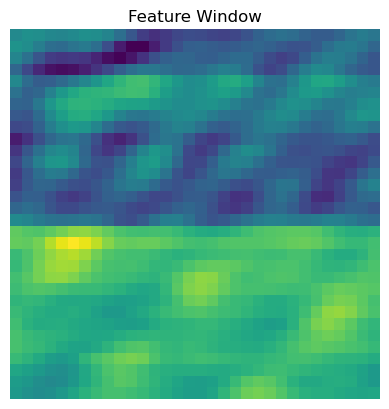

In [75]:
# show one image with specific index from train_dataset
for i, (x, y) in enumerate(train_dataset_feature_windows):
    if i == 0:  # Show only the first batch
        print(f"Batch {i}:")
        print(f"x shape: {x.shape}, y shape: {y.shape}")
        plt.imshow(x[2].numpy().squeeze(), cmap='viridis')
        plt.title('Feature Window')
        plt.axis('off')
        plt.show()
    break


Batch 0:
x shape: (799, 32, 32, 1), y shape: (799, 32, 32, 1)


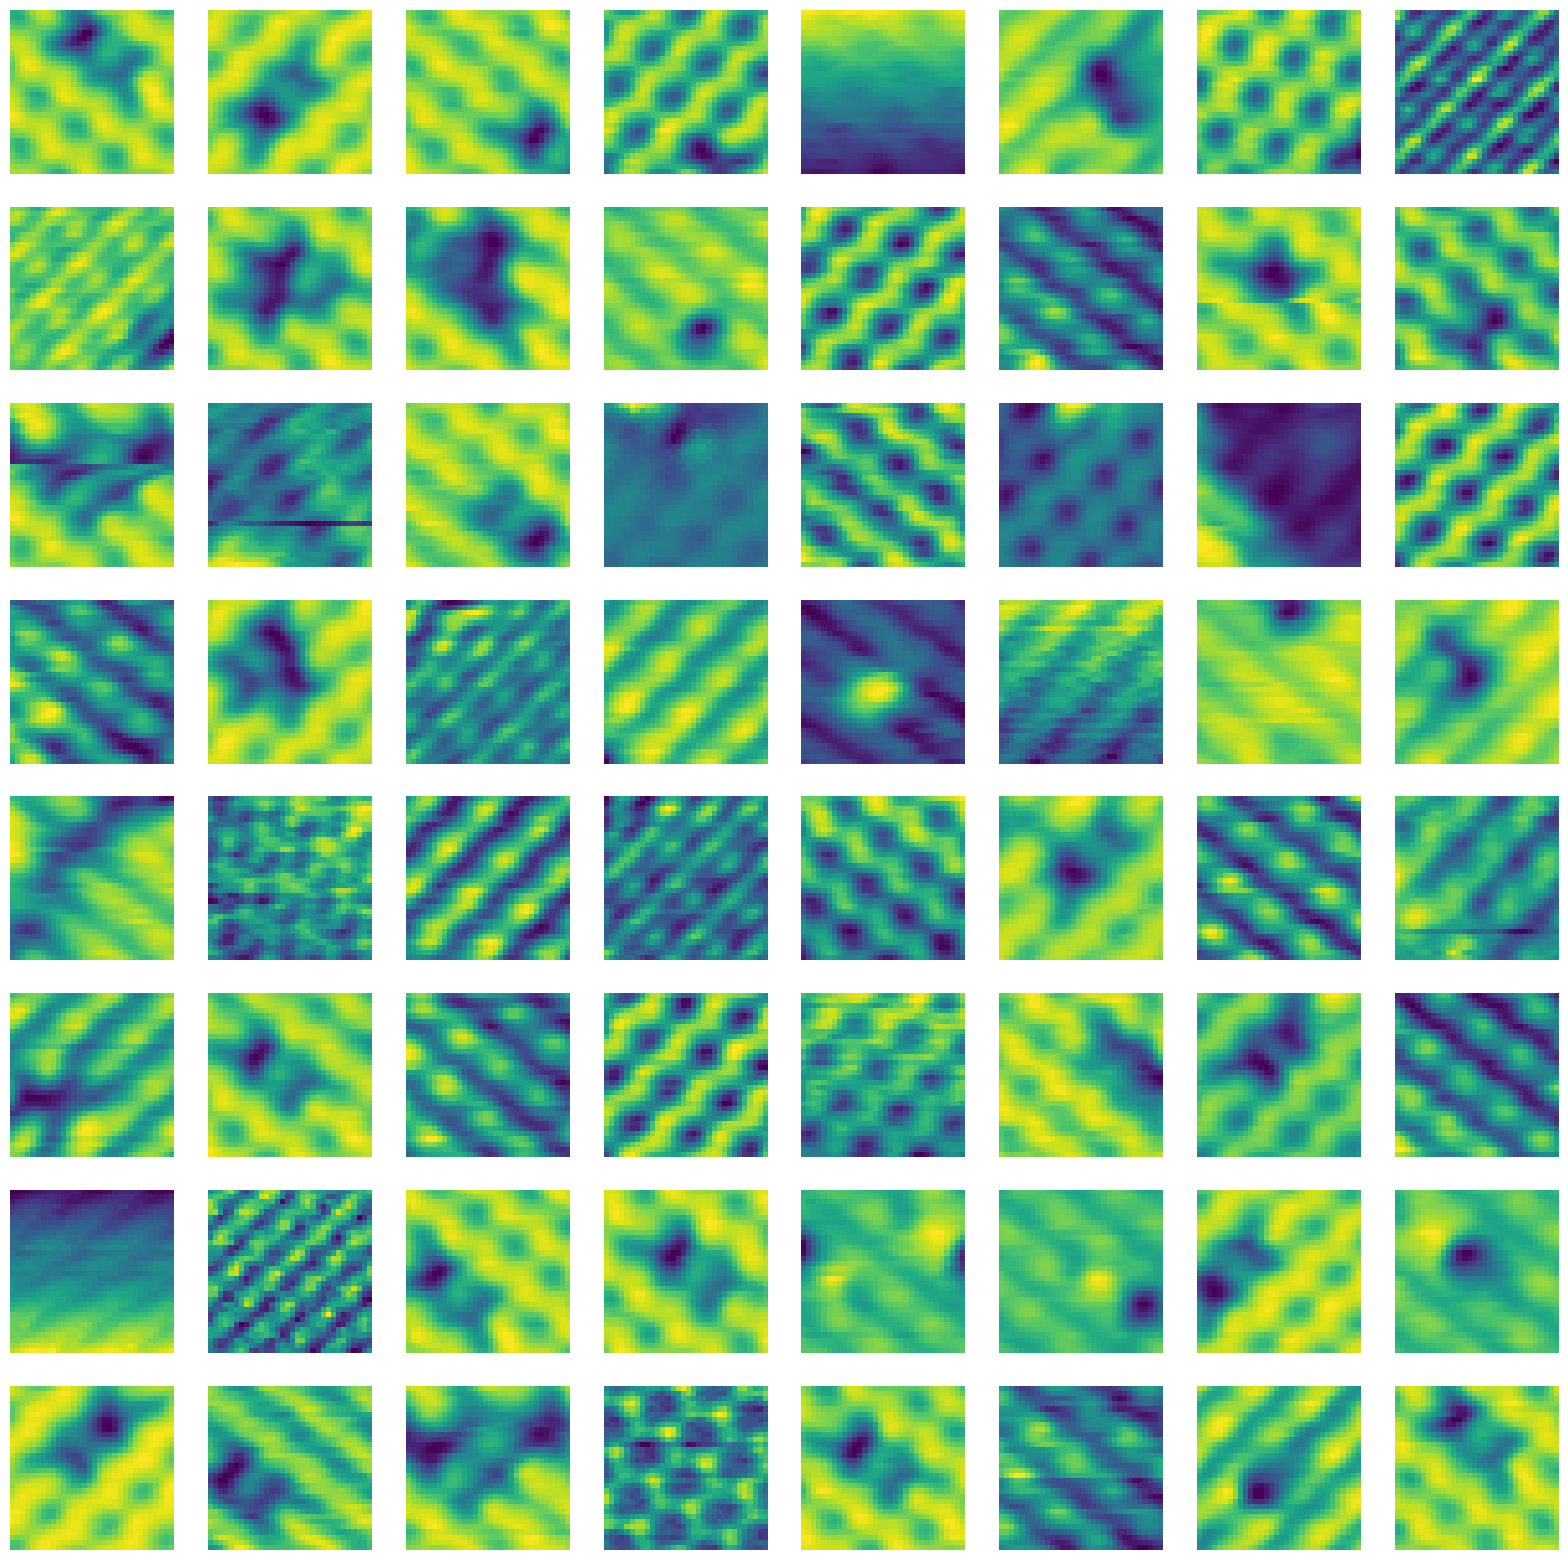

In [76]:
# Display the first 16 images in a 4x4 grid along with their labels
def display_images_with_labels(images, labels, num_images=16):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

num_images = 64
offset = 400
# show one image with specific index from train_dataset
for i, (x, y) in enumerate(train_dataset_feature_windows):
    if i == 0:  # Show only the first batch
        print(f"Batch {i}:")
        print(f"x shape: {x.shape}, y shape: {y.shape}")
        plt.figure(figsize=(20, 20))
        for index in range(num_images):
            plt.subplot(8, 8, index + 1)
            plt.imshow(x[index + offset].numpy().squeeze(), cmap='viridis')
            #plt.title(f'Label: {labels[index+offset]}')
            plt.axis('off')
        
        plt.show()
    break


In [ ]:
dp.delete_data_folders(job_data_path, subdirectories=["feature_windows_latent/train"], override=True)


m.extract_latent_features_to_disk_from_prebatched_windows(
    autoencoder_model, 
    train_dataset_feature_windows, 
    train_feature_windows_latent_path, 
    bottleneck_layer_name='bottleneck',
    features_name='feature_windows_latent_features_train',
    return_array=False,
    verbose=True)

Deleted: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows_latent/train
All specified folders have been successfully deleted.
Processing batch 1, input shape: [799  32  32   1]
Latent features shape for batch 1: (799, 4096)
Saved latent features for batch 1 to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows_latent/train/feature_windows_latent_features_train_batch_0.npy

All latent features have been saved to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows_latent/train.
Sample batch shape: (799, 4096)


### Train K-Means using latent features saved to disk

In [26]:
# List and sort latent feature files
train_feature_windows_latent_features_files, num_latent_files = dp.list_files_by_extension(train_feature_windows_latent_path, 'npy')

Found 1 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows_latent/train


In [27]:
print(train_feature_windows_latent_features_files)

['/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows_latent/train/feature_windows_latent_features_train_batch_0.npy']


In [28]:
# simple method for kmeans
def load_numpy_file(file_path):
        data = np.load(file_path)
        return data

def tf_load_numpy_file(file_path):
    data = tf.py_function(load_numpy_file, [file_path], tf.float32)
    return tf.data.Dataset.from_tensor_slices(data)

data = load_numpy_file(train_feature_windows_latent_features_files[0])

from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
#
#kmeans = KMeans(n_clusters=4, random_state=42)
#labels = kmeans.fit_predict(data)
#
#sil_score = silhouette_score(data, labels)
#print(f"Silhouette Score: {sil_score:.3f}")#

In [29]:
# Load the latent features from disk into a tensor dataset pipeline
train_feature_windows_latent_features_dataset = m.create_latent_features_tf_dataset(
    train_feature_windows_latent_features_files,
    batch_size=cluster_batch_size,
    shuffle=True, 
    shuffle_buffer_size=cluster_buffer_size)

Data pipeline created with 1 files, batch size: 5120
Shuffling enabled with buffer size: 25600
Batch shape: (799, 4096)


### DBSCAN

In [48]:
cluster_model_dbscan = m.train_dbscan(
    train_feature_windows_latent_features_dataset,
    eps = 0.7,
    min_samples = 5)

Batch 1 processed


In [49]:
print(f"Number of clusters found: {len(set(cluster_model_dbscan.labels_)) - (1 if -1 in cluster_model_dbscan.labels_ else 0)}")

Number of clusters found: 4


### Spectral clustering

In [166]:
cluster_model_spectral = m.train_spectral_clustering(train_feature_windows_latent_features_dataset, n_clusters=5, affinity='nearest_neighbors', n_neighbors=10)

### K-means

In [128]:

cluster_model_feature_windows, convergence_history = m.train_kmeans(
    train_feature_windows_latent_features_dataset,                # tf.data.Dataset containing batches of latent feature vectors.
    batch_size=cluster_batch_size,          # Size of each batch for the KMeans model (controls memory usage and stability).
    num_clusters=4,              # Desired number of clusters (centroids) to form in the data.
    max_iter=5000000,                      # Maximum iterations allowed for each mini-batch to refine centroids.
    reassignment_ratio=0.01   # Fraction of clusters reassigned per step; lower values stabilize updates.
)
# Save and plot convergence history
m.plot_kmeans_convergence(convergence_history, cluster_model_feature_windows_path, model_name=cluster_model_name)

# Save cluster model
m.save_cluster_model(cluster_model_feature_windows, cluster_model_feature_windows_path, model_name=cluster_model_name)

Batch 1 processed. Inertia: 227.47901916503906
[Warning] Not enough data to plot convergence.
Cluster model saved at: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/cluster_model_feature_windows/unet_June_25_BIG_model_kmeans.pkl


In [129]:
# Display the first 16 images in a 4x4 grid along with their labels
def display_images_with_labels(images, labels, num_images=16):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

num_images = 64
offset = 0
# show one image with specific index from train_dataset
for i, (x, y) in enumerate(train_dataset_feature_windows):
    if i == 5:  # Show only the first batch
        print(f"Batch {i}:")
        print(f"x shape: {x.shape}, y shape: {y.shape}")
        plt.figure(figsize=(20, 20))
        for index in range(num_images):
            plt.subplot(8, 8, index + 1)
            plt.imshow(x[index + offset].numpy().squeeze(), cmap='viridis')
            #plt.title(f'Label: {labels[index+offset]}')
            plt.axis('off')
        
        plt.show()
    break


Error loading file /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/train/default_2011Jan28-112629_STM-STM_Spectroscopy--7_1_BU_all_windows_all_windows.npy: [Errno 2] No such file or directory: '/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/train/default_2011Jan28-112629_STM-STM_Spectroscopy--7_1_BU_all_windows_all_windows.npy'
Error loading file /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/train/default_2011Jan28-112629_STM-STM_Spectroscopy--4_1_FU_all_windows_all_windows.npy: [Errno 2] No such file or directory: '/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/train/default_2011Jan28-112629_STM-STM_Spectroscopy--4_1_FU_all_windows_all_windows.npy'
Error loading file /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/train/default_2011Jan28-160009_STM-STM_Spectroscopy--3_1_BU_all_windows_all_windows.npy: [Errno 2] No such file or directory: '/hpc/aklicka/P

UnknownError: UnboundLocalError: local variable 'batch' referenced before assignment
Traceback (most recent call last):

  File "/hpc/aklicka/Python/modules/SRSML24/model.py", line 205, in load_batched_numpy_file
    batch = np.load(file_path)  # Load the numpy file

  File "/hpc/aklicka/.conda/envs/tf-adam/lib/python3.9/site-packages/numpy/lib/npyio.py", line 405, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))

FileNotFoundError: [Errno 2] No such file or directory: '/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/train/default_2011Jan28-112629_STM-STM_Spectroscopy--14_1_FU_all_windows_all_windows.npy'


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/hpc/aklicka/.conda/envs/tf-adam/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 247, in __call__
    return func(device, token, args)

  File "/hpc/aklicka/.conda/envs/tf-adam/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 135, in __call__
    ret = self._func(*args)

  File "/hpc/aklicka/.conda/envs/tf-adam/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/temp/46580.1.I_40T_64G_NVIDIA_TeslaT4_16G.q/tmpweggyt18.py", line 14, in <lambda>
    retval_ = ag__.converted_call(ag__.ld(tf).py_function, (), dict(func=ag__.autograph_artifact((lambda fp: ag__.converted_call(ag__.ld(load_batched_numpy_file), (ag__.ld(fp), ag__.ld(window_size)), None, fscope))), inp=[ag__.ld(file_path)], Tout=ag__.ld(tf).float32), fscope)

  File "/hpc/aklicka/.conda/envs/tf-adam/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 354, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/hpc/aklicka/.conda/envs/tf-adam/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 479, in _call_unconverted
    return f(*args)

  File "/hpc/aklicka/Python/modules/SRSML24/model.py", line 216, in load_batched_numpy_file
    print('Please check that the data has window_size ({},{}). Possible mismatch with supplied data: {}'.format(window_size,window_size,batch.shape[1:]))

UnboundLocalError: local variable 'batch' referenced before assignment


	 [[{{node EagerPyFunc}}]]

### Testing on prediction dataset

In [99]:
predict_files, num_predict = dp.list_files_by_extension(windows_predict_path, 'npy')

# Get the corresponding image coordimages list file
prediction_windows_coordinates_file_list , _ = dp.list_files_by_extension(windows_predict_path,'.txt',verbose=False)
prediction_windows_coordinates_file_list = [
    name for name in prediction_windows_coordinates_file_list 
    if "coordinates" in name
]


Found 32 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/predict
Found 64 files with extension '.txt' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/predict


In [100]:
dp.delete_data_folders(job_data_path, subdirectories=["feature_windows/predict"], override=True)

for image_num in range(len(predict_files)):
    prediction_file = predict_files[image_num]  
    coords_file = prediction_windows_coordinates_file_list[image_num]  

    #get reconstructed image and cluster image
    reconstructed_img, cluster_img = m.reconstruct_predict(prediction_file, coords_file, autoencoder_model, cluster_model, window_size, predictions_batch_size)

    # Detect features and find centers
    #labeled_array, centers, num_features = m.detect_features_better(cluster_img, max_size=max_size_blob, area_threshold=area_threshold)
    features, centers, labeled_array, num_features = m.detect_features_find_centres(cluster_img, max_size=70000, area_threshold=64,)


    #extract feature windows from the reconstructed image
    feature_windows = m.extract_feature_windows(reconstructed_img, centers, px=feature_size)

    image_name = os.path.splitext(os.path.basename(prediction_file))[0]
    # Save the feature windows to disk for each reconstructed image
    dp.save_feature_windows_together(feature_windows, centers, predict_feature_windows_path, base_filename=image_name, verbose=True)

    #save / display the reconstructed and cluster images with centers highlighted
    m.display_reconstructed_and_cluster_images_and_extracted_features(reconstructed_img, cluster_img, labeled_array, centers,
                                                                      save_to_disk=True, output_path=feature_predictions_path, image_name=image_name, dpi=150)

No target folders found to delete.

---
Processing file default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BD_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (32768, 32, 32, 1)
......Combined latent features shape: (189225, 4096)
Saved 77 windows to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/predict/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BD_all_windows_all_windows.npy
Saved coordinates to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/predict/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BD_all_windows_coordinates.txt

Image saved to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_predictions/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BD_all_windows.jpg with dpi=150

---
Processing file default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BU_all_windows.npy
Not shuffling
Data pipeline created with 1 fi

Found 32 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/predict
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (15, 32, 32, 1)

Deleted: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows_latent/predict
All specified folders have been successfully deleted.
Processing batch 1, input shape: [15 32 32  1]
Latent features shape for batch 1: (15, 4096)
Saved latent features for batch 1 to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows_latent/predict/feature_windows_latent_features_predict_batch_0.npy

All latent features have been saved to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows_latent/predict.
Sample batch shape: (15, 4096)
Found 1 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows_latent/predict
Data pipeline created wi

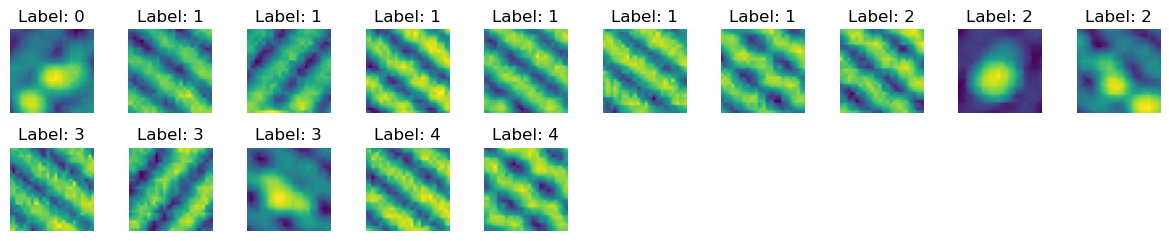

In [330]:
# Prediction data - tensorflow data pipeline 
predict_files, num_predict = dp.list_files_by_extension(predict_feature_windows_path, 'npy')

#for image_num in range(len(predict_files)):
image_num = 25

#create a dataset for each image
predict_dataset = m.create_tf_dataset_batched(
    predict_files[image_num:image_num+1],  # Use only one file for predictions
    batch_size=predictions_batch_size, 
    #buffer_size=cluster_buffer_size, 
    window_size=feature_size*2,  # feature windows are 2*feature_size
    is_autoencoder=True, 
    shuffle=False)

dp.delete_data_folders(job_data_path, subdirectories=["feature_windows_latent/predict"], override=True)

#create latent features for each image
m.extract_latent_features_to_disk_from_prebatched_windows(
    autoencoder_model, 
    predict_dataset, 
    predict_feature_windows_latent_path, 
    bottleneck_layer_name='bottleneck',
    features_name='feature_windows_latent_features_predict',
    return_array=False,
    verbose=True)

predict_feature_windows_latent_features_files, num_latent_files = dp.list_files_by_extension(predict_feature_windows_latent_path, 'npy')

# Load the latent features from disk into a tensor dataset pipeline
predict_feature_windows_latent_features_dataset = m.create_latent_features_tf_dataset(
    predict_feature_windows_latent_features_files,
    batch_size=cluster_batch_size,
    shuffle=False, 
    shuffle_buffer_size=cluster_buffer_size)

# Load a previously saved cluster model from disk
cluster_model_feature_windows = m.load_cluster_model(cluster_model_feature_windows_path, model_name=cluster_model_name)


data = load_numpy_file(predict_feature_windows_latent_features_files[0])

#labels = cluster_model_feature_windows.predict(data)
labels = cluster_model_spectral.fit_predict(data)

image = np.load(predict_files[image_num])

# Sort the labels numerically, while also sorting the corresponding feature windows
sorted_indices = np.argsort(labels)
sorted_labels = labels[sorted_indices]
sorted_feature_windows = image[sorted_indices]
# Display the first 64 images in a 8x8 grid along with their labels
def display_images_with_labels(images, labels, num_images=64):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(10, 10, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
display_images_with_labels(sorted_feature_windows, sorted_labels, num_images=image.shape[0])


In [299]:
print(image.shape[0])

77


Found 32 files with extension 'jpg' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_predictions


(-0.5, 2699.5, 899.5, -0.5)

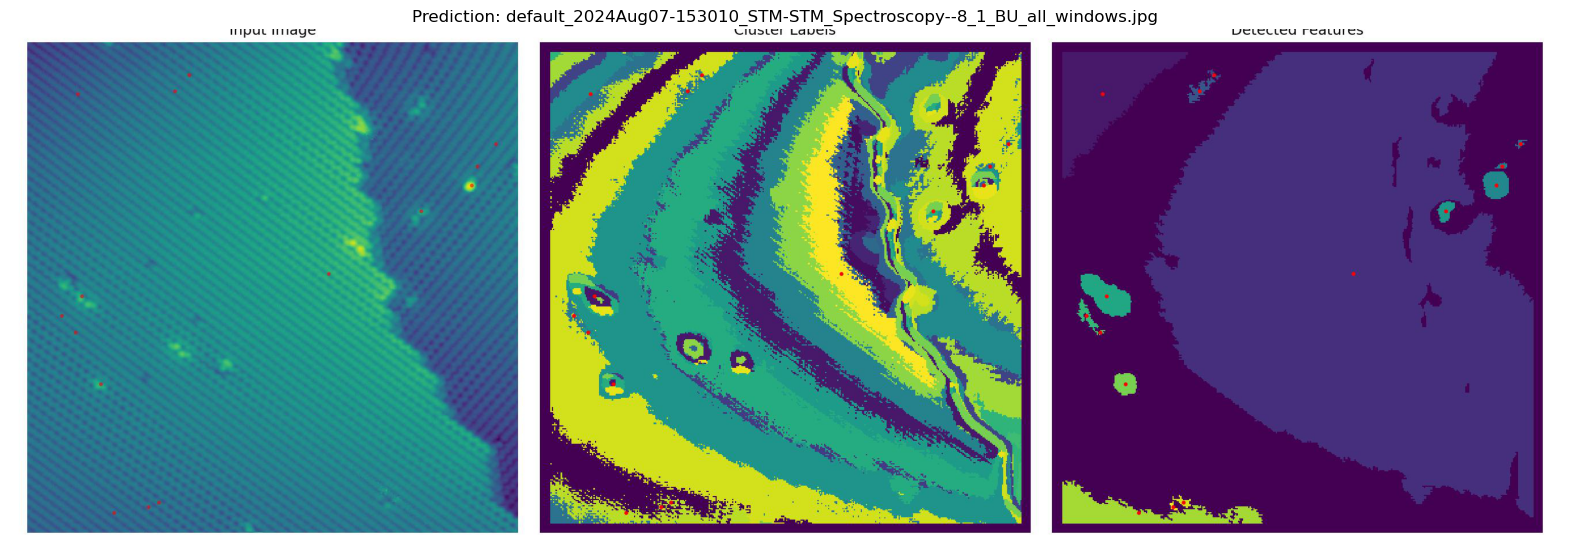

In [331]:
jpg_predictions_files, num_jpg_predict = dp.list_files_by_extension(feature_predictions_path, 'jpg')
#display a jpg prediction with index jpg_predictions_files[0]
jpg_prediction_file = jpg_predictions_files[image_num]
jpg_prediction = ski.io.imread(jpg_prediction_file)
plt.figure(figsize=(20, 10))
plt.imshow(jpg_prediction, cmap='viridis')
plt.title(f'Prediction: {os.path.basename(jpg_prediction_file)}')
plt.axis('off')

In [243]:
print(predict_files)

['/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/predict/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BD_all_windows_all_windows.npy', '/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/predict/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_BU_all_windows_all_windows.npy', '/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/predict/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_FD_all_windows_all_windows.npy', '/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/predict/default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_FU_all_windows_all_windows.npy', '/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/predict/default_2011Mar10-162902_STM-STM_Spectroscopy--1_3_BD_all_windows_all_windows.npy', '/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/predict/default_2011Mar10-162902_STM-STM_Spectroscopy--1_3_BU_all_windows_all

Batch 0:
x shape: (1020, 32, 32, 1), y shape: (1020, 32, 32, 1)


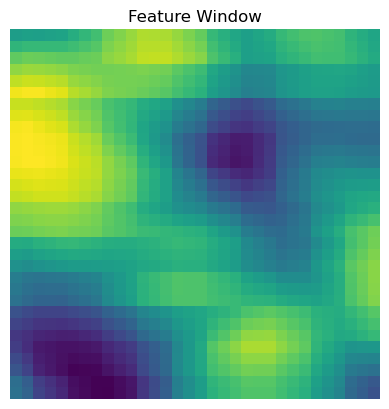

In [156]:
# show one image with specific index from train_dataset
for i, (x, y) in enumerate(predict_dataset):
    if i == 0:  # Show only the first batch
        print(f"Batch {i}:")
        print(f"x shape: {x.shape}, y shape: {y.shape}")
        plt.imshow(x[700].numpy().squeeze(), cmap='viridis')
        plt.title('Feature Window')
        plt.axis('off')
        plt.show()
    break

In [158]:
# List and sort latent feature files
predict_feature_windows_latent_features_files, num_latent_files = dp.list_files_by_extension(predict_feature_windows_latent_path, 'npy')

Found 1 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows_latent/predict


In [159]:
# Load the latent features from disk into a tensor dataset pipeline
predict_feature_windows_latent_features_dataset = m.create_latent_features_tf_dataset(
    predict_feature_windows_latent_features_files,
    batch_size=cluster_batch_size,
    shuffle=False, 
    shuffle_buffer_size=cluster_buffer_size)

Data pipeline created with 1 files, batch size: 5120
Batch shape: (1020, 4096)


In [229]:
# Load a previously saved cluster model from disk
cluster_model_feature_windows = m.load_cluster_model(cluster_model_feature_windows_path, model_name=cluster_model_name)


data = load_numpy_file(predict_feature_windows_latent_features_files[0])
#labels = cluster_model_feature_windows.predict(data)
#labels = cluster_model_dbscan.fit_predict(data)

labels = cluster_model_spectral.fit_predict(data)
print(data.shape)

Cluster model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/cluster_model_feature_windows/unet_June_25_BIG_model_kmeans.pkl
(1020, 4096)


(77, 32, 32)
(77,) (66,)
(77,)


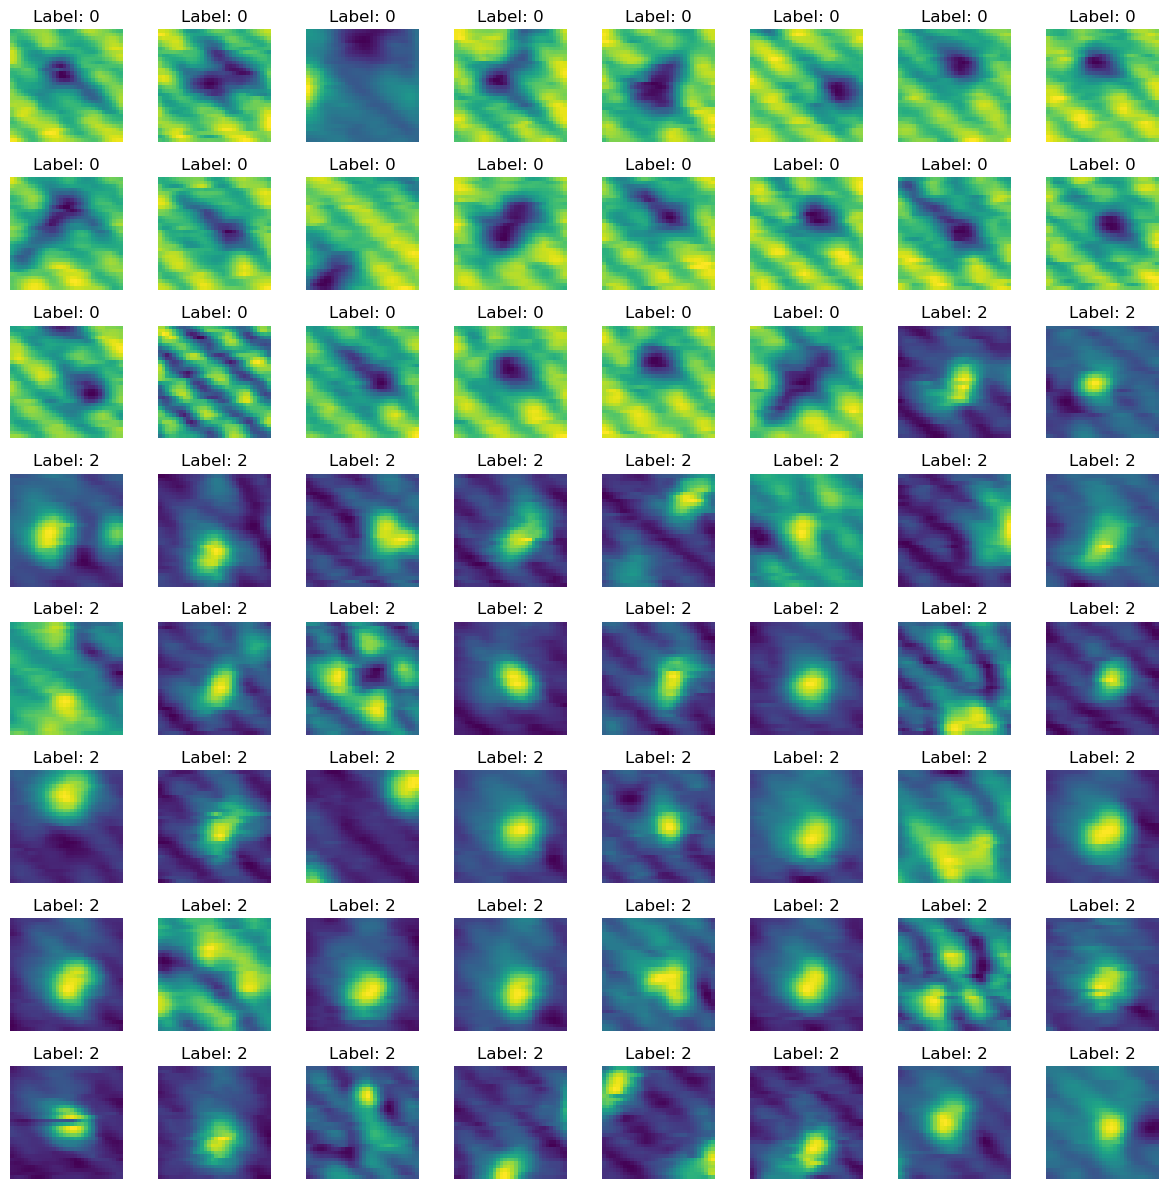

In [242]:
image1 = np.load(predict_files[0])
image2 = np.load(predict_files[1])
print(image1.shape)
labels_image1 = labels[:image1.shape[0]]
labels_image2 = labels[image1.shape[0]:image1.shape[0] + image2.shape[0]]
print(labels_image1.shape, labels_image2.shape)
print(labels_image1.shape)
# Sort the labels numerically, while also sorting the corresponding feature windows
sorted_indices = np.argsort(labels_image2)
sorted_labels = labels_image2[sorted_indices]
sorted_feature_windows = image2[sorted_indices]
# Display the first 64 images in a 8x8 grid along with their labels
def display_images_with_labels(images, labels, num_images=64):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(8, 8, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
display_images_with_labels(sorted_feature_windows, sorted_labels, num_images=64)


In [213]:


print(data.shape)
print(labels.shape)
combined_data = np.hstack((data, labels.reshape(-1, 1)))
print(labels.reshape(-1,1))
print(combined_data)

(1020, 4096)
(1020,)
[[0]
 [2]
 [0]
 ...
 [0]
 [0]
 [0]]
[[0.01132562 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         2.        ]
 [0.00792065 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [214]:
sorted_combined_data = np.sort(combined_data, axis=0)
print(sorted_combined_data)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.03883015e-02 0.00000000e+00 3.19244852e-03 ... 0.00000000e+00
  0.00000000e+00 4.00000000e+00]
 [2.20583454e-02 0.00000000e+00 3.90294334e-03 ... 0.00000000e+00
  0.00000000e+00 4.00000000e+00]
 [2.43796427e-02 0.00000000e+00 4.33872780e-03 ... 0.00000000e+00
  0.00000000e+00 4.00000000e+00]]


In [225]:
print(sorted_combined_data[0,:-1].shape)

(4096,)


In [196]:
print(np.array([1,1,1],).shape)

(3,)


In [210]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

score = calinski_harabasz_score(data, labels)
print(f"Calinski-Harabasz Score: {score:.3f}")

sil_score = silhouette_score(data, labels)
print(f"Silhouette Score: {sil_score:.3f}")#

Calinski-Harabasz Score: 364.503
Silhouette Score: 0.260


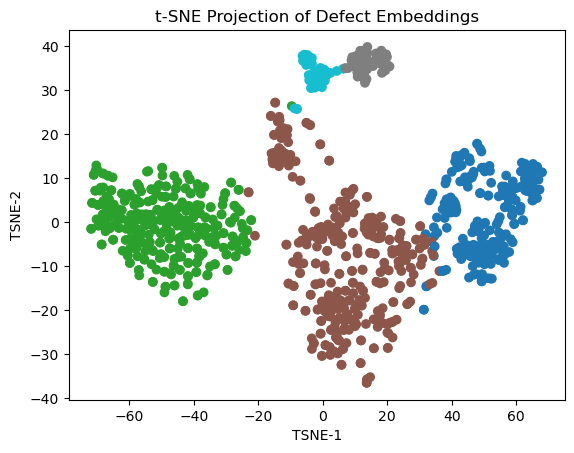

In [211]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(data)

plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10')
plt.title('t-SNE Projection of Defect Embeddings')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
#plt.legend(labels.unique(labels), title='Cluster Labels', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

In [182]:
print(labels.shape)

(1020,)


In [207]:
print(enumerate(predict_dataset))

Batch 0:
x shape: (1020, 32, 32, 1), y shape: (1020, 32, 32, 1)


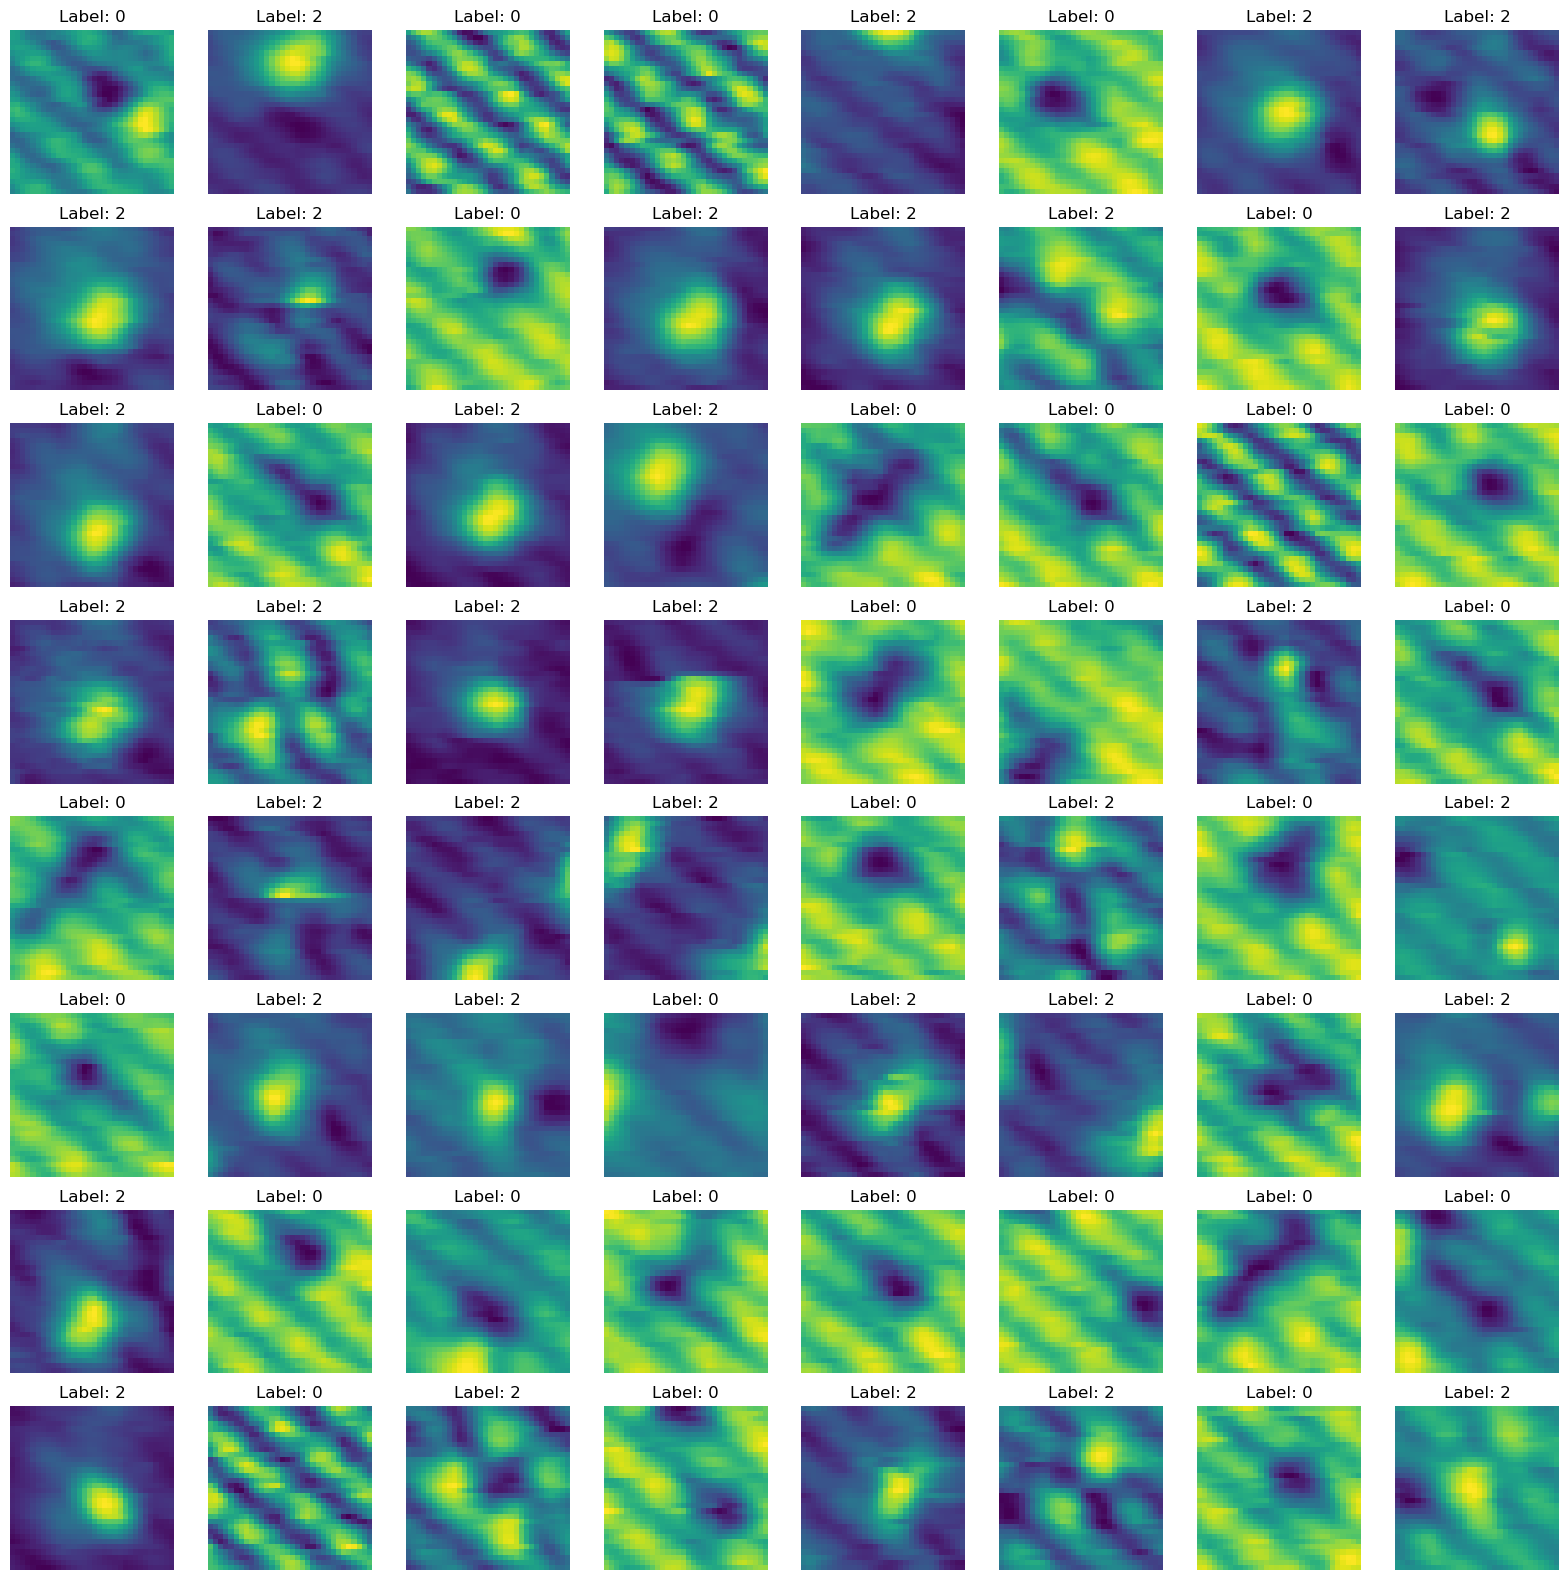

In [212]:
# Display the first 16 images in a 4x4 grid along with their labels
def display_images_with_labels(images, labels, num_images=16):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


num_images = 64
offset = 0
# show one image with specific index from train_dataset
for i, (x, y) in enumerate(predict_dataset):
    if i == 0:  # Show only the first batch
        print(f"Batch {i}:")
        print(f"x shape: {x.shape}, y shape: {y.shape}")
        plt.figure(figsize=(20, 20))
        for index in range(num_images):
            plt.subplot(8, 8, index + 1)
            plt.imshow(x[index + offset].numpy().squeeze(), cmap='viridis')
            plt.title(f'Label: {labels[index+offset]}')
            plt.axis('off')
        
        plt.show()
    break


### testing out the feature detection

In [78]:
# Load a previously saved cluster model from disk
cluster_model = m.load_cluster_model(cluster_model_path, model_name=cluster_model_name)

# Get the list of image windows files to make predictions on
predict_data_files_list, predict_data_files_num = dp.list_files_by_extension(windows_predict_path,'.npy',verbose=False)
# Get the corresponding image coordimages list file
image_windows_coordinates_file_list , _ = dp.list_files_by_extension(windows_predict_path,'.txt',verbose=False)
image_windows_coordinates_file_list = [
    name for name in image_windows_coordinates_file_list 
    if "coordinates" in name
]#

Cluster model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/cluster_model/unet_June_25_BIG_model_kmeans.pkl
Found 32 files with extension '.npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/predict
Found 64 files with extension '.txt' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/predict


In [ ]:
data = cluster_img.astype("int32")
print(np.bincount(data.ravel()))

In [ ]:
image_num = 31
prediction_file = predict_data_files_list[image_num]  
coords_file = image_windows_coordinates_file_list[image_num]  

#get reconstructed image and cluster image
reconstructed_img, cluster_img = m.reconstruct_predict(prediction_file, coords_file, autoencoder_model, cluster_model, window_size, predictions_batch_size)

data = cluster_img.astype("int32")
print(np.bincount(data.ravel()))

# Detect features and find centers
features, centers, labeled_array, num_features = m.detect_features_find_centres(cluster_img, max_size=70000, area_threshold=64)
#display the images and extracted features
m.display_reconstructed_and_cluster_images_and_extracted_features(
    reconstructed_img, 
    cluster_img, 
    features, 
    centers, 
    save_to_disk=False,
)


---
Processing file default_2024Aug07-153010_STM-STM_Spectroscopy--8_1_BU_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (32768, 32, 32, 1)
....Combined latent features shape: (129600, 4096)
[81116  5800 32988  3008    20  6776  8912   124     0  8404   516 15320
  2420 30792 24392 72432 26184     0 57620  2628   696     0     0  6984
 25664  7788 34516 86708  3520 17172]
Method 1


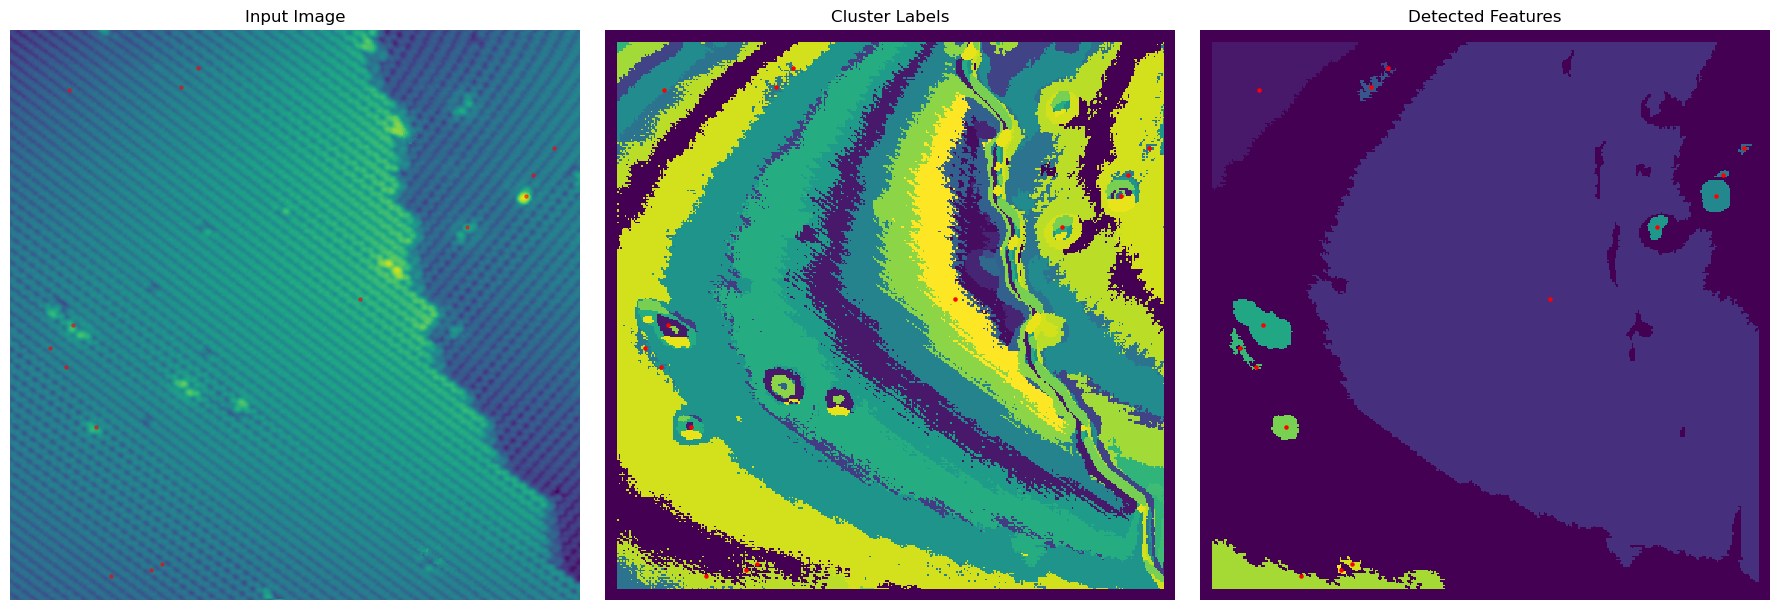

/hpc/aklicka/.conda/envs/tf-adam/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:1534: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


Method 2


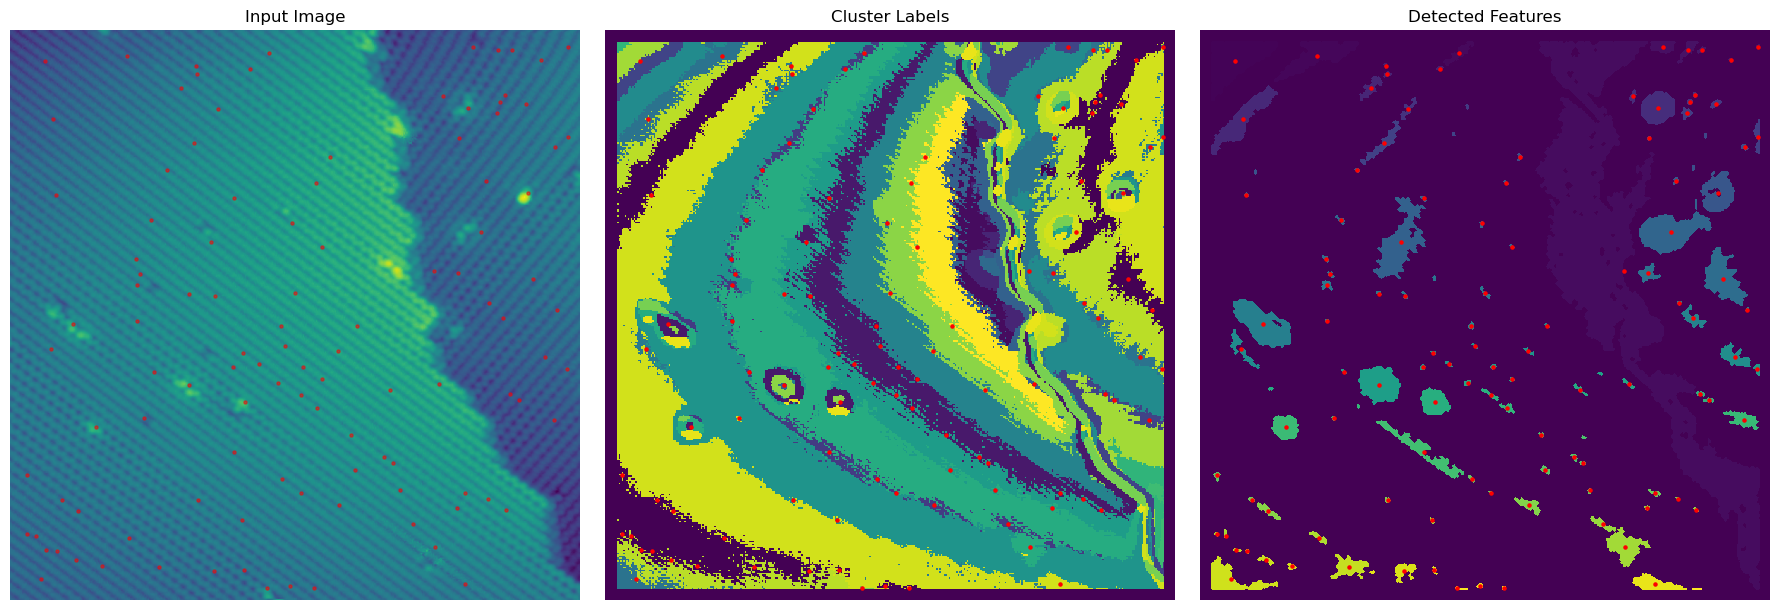

In [98]:
image_num = 25
prediction_file = predict_data_files_list[image_num]  
coords_file = image_windows_coordinates_file_list[image_num]  

#get reconstructed image and cluster image
reconstructed_img, cluster_img = m.reconstruct_predict(prediction_file, coords_file, autoencoder_model, cluster_model, window_size, predictions_batch_size)

data = cluster_img.astype("int32")
print(np.bincount(data.ravel()))

# Detect features and find centers
features, centers, labeled_array, num_features = m.detect_features_find_centres(cluster_img, max_size=70000, area_threshold=64)
print("Method 1")
#display the images and extracted features
m.display_reconstructed_and_cluster_images_and_extracted_features(
    reconstructed_img, 
    cluster_img, 
    features, 
    centers, 
    save_to_disk=False,
)

labeled_array, centers, num_features = m.detect_features_better(cluster_img, max_size=3000, area_threshold=10)
#display the images and extracted features
print("Method 2")
m.display_reconstructed_and_cluster_images_and_extracted_features(
    reconstructed_img, 
    cluster_img, 
    labeled_array, 
    centers, 
    save_to_disk=False,
)

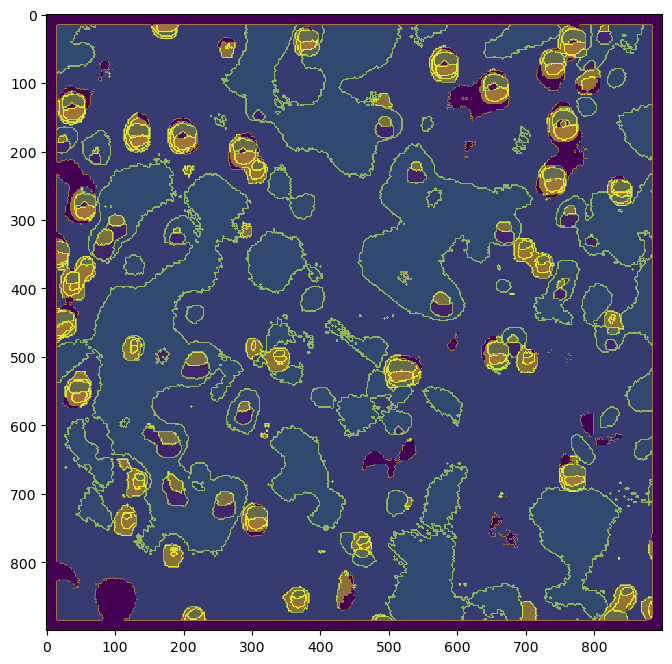

In [90]:
import skimage
#convert reconstructed_img to grayscale if it is not already
#reconstructed_img_gray = skimage.color.rgb2gray(reconstructed_img)
#boundaries = ski.measure.find_contours(features, 0.5)
data = cluster_img.astype("int32")
boundaries = skimage.segmentation.find_boundaries(data, mode="outer")
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figsize (width, height) as desired
ax.imshow(cluster_img, cmap='viridis', interpolation='nearest')
ax.imshow(boundaries, cmap='viridis', interpolation='nearest', alpha=0.5)  # Overlay boundaries with some transparency


In [91]:
import scipy
# Create a copy to work with
boundary_image = boundaries.astype(int)

# Label connected components (regions between boundaries)
labeled_regions, num_regions = scipy.ndimage.label(~boundaries)

# Calculate area of each region
areas = {}
for region_id in range(1, num_regions + 1):
    area = np.sum(labeled_regions == region_id)
    areas[region_id] = area

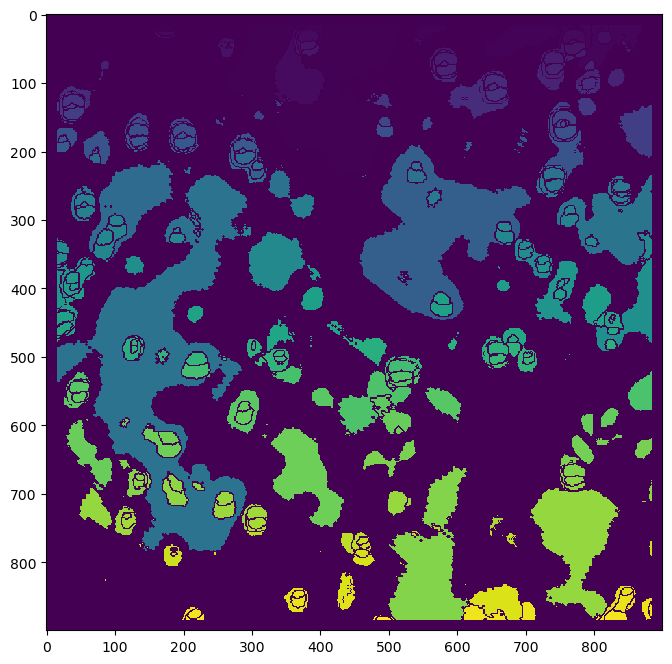

In [92]:
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figsize (width, height) as desired
ax.imshow(labeled_regions, cmap='viridis', interpolation='nearest')

In [93]:
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt

image_gray = labeled_regions.astype(float)
blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=0.1)
print("Number of blobs detected using LoG:", len(blobs_log))
# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
print("Number of blobs detected using DoG:", len(blobs_dog))

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=0.01)
print
blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(labeled_regions, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

Number of blobs detected using LoG: 6678
Number of blobs detected using DoG: 4517


KeyboardInterrupt: 

In [94]:
blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
print("Number of blobs detected using DoG:", len(blobs_dog))

Number of blobs detected using DoG: 4517


In [ ]:
print(blobs_dog[:])

[[788.         247.           1.41421356]
 [884.         479.           1.41421356]
 [884.         805.           1.41421356]
 ...
 [381.         407.           1.41421356]
 [384.         407.           1.41421356]
 [ 48.         279.           1.41421356]]


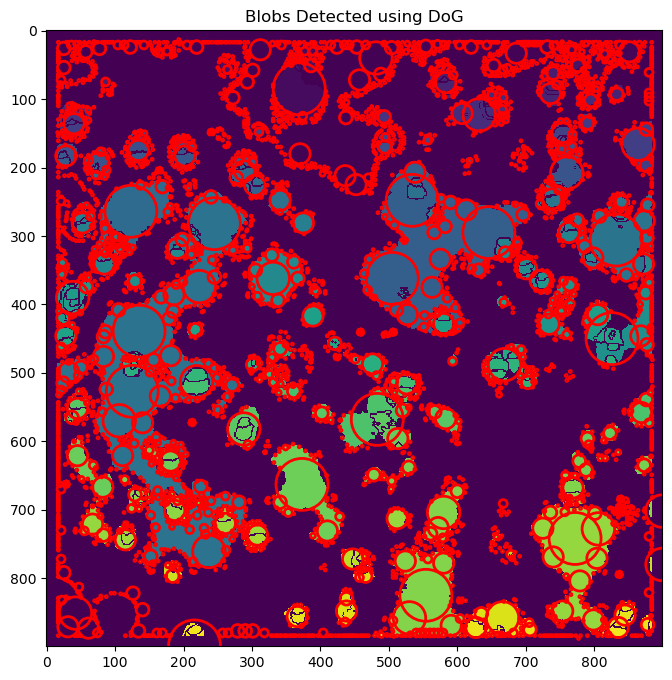

In [97]:
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figsize (width, height) as desired
color = 'red'  # Color for the circles
ax.set_title('Blobs Detected using DoG')
ax.imshow(labeled_regions, interpolation='nearest')
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
    ax.add_patch(c)

In [ ]:
element = np.array([[0,1,0],
                    [1,1,1],
                    [0,1,0]])
area_threshold = 14  # Define the area threshold for morphological operations
data = cluster_img.astype("int32")
boundaries = skimage.segmentation.find_boundaries(data, mode="outer")

# Create a copy to work with
boundary_image = boundaries.astype(int)

# Label connected components (regions between boundaries)
labeled_regions, num_regions = scipy.ndimage.label(~boundaries)

# Calculate area of each region
areas = {}
for region_id in range(1, num_regions + 1):
    area = np.sum(labeled_regions == region_id)
    areas[region_id] = area
    
large_removed = m.remove_large_objects(labeled_regions, max_size=3000)

eroded = large_removed
#eroded = morphology.binary_erosion(large_removed, element)  # Erode the image to remove small features
#eroded = morphology.binary_erosion(eroded, element)  # Erode again to further refine the features
#eroded = morphology.binary_erosion(eroded, element)  # Erode again to further refine the features

#eroded = morphology.remove_small_objects(eroded, min_size=area_threshold)  # Remove small objects based on area threshold
#area_closed = morphology.area_closing(large_removed, area_threshold=area_threshold)  # Apply closing operation to fill small holes
#area_opened = morphology.area_opening(area_closed, area_threshold=area_threshold)  # Apply opening operation to remove small objects
#
#foreground = area_opened > 0  # Convert to boolean type for morphological operations
#dilated = morphology.binary_dilation(foreground, morphology.disk(1))  # Dilate the foreground to connect nearby features
#labeled_array, num_features = scipy.ndimage.label(dilated)  # Use a 3x3 structure for connectivity
#
centers = scipy.ndimage.center_of_mass(eroded, labeled_array, range(1, num_features + 1))
centers = np.array(centers)  # Convert to numpy array for easier manipulation


fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figsize (width, height) as desired
ax.imshow(eroded, cmap='viridis', interpolation='nearest')
ax.scatter(centers[:,1], centers[:,0], color='red', s=5, label='Centroids')  # Plot centroids

In [ ]:
print(areas)

In [ ]:
def detect_features_better(cluster_img, max_size=3000, area_threshold=10):
    
    data = cluster_img.astype("int32")
    boundaries = skimage.segmentation.find_boundaries(data, mode="outer")

    element = np.array([[0,1,0],
                    [1,1,1],
                    [0,1,0]])
    
    # Create a copy to work with
    boundary_image = boundaries.astype(int)

    # Label connected components (regions between boundaries)
    labeled_regions, num_regions = scipy.ndimage.label(~boundaries)

    # Calculate area of each region
    areas = {}
    for region_id in range(1, num_regions + 1):
        area = np.sum(labeled_regions == region_id)
        areas[region_id] = area
        
    large_removed = m.remove_large_objects(labeled_regions, max_size=max_size)

    area_closed = morphology.area_closing(large_removed, area_threshold=area_threshold)  # Apply closing operation to fill small holes
    area_opened = morphology.area_opening(area_closed, area_threshold=area_threshold)  # Apply opening operation to remove small objects

    foreground = area_opened > 0  # Convert to boolean type for morphological operations
    dilated = morphology.binary_dilation(foreground, morphology.disk(1))  # Dilate the foreground to connect nearby features
    closed = morphology.binary_closing(dilated, morphology.disk(2))  # Close small gaps in the foreground
    labeled_array, num_features = scipy.ndimage.label(closed)  # Use a 3x3 structure for connectivity

    #clearning the background
    closed = morphology.closing(labeled_array, morphology.disk(2))  # Close small gaps in the foreground
    opened = morphology.opening(closed, morphology.disk(2))  # Open small gaps in the foreground
    
    centers = scipy.ndimage.center_of_mass(opened, labeled_array, range(1, num_features + 1))
    centers = np.array(centers)  # Convert to numpy array for easier manipulation

    
    return labeled_array, centers, num_features

In [ ]:
image_num = 29
prediction_file = predict_data_files_list[image_num]  
coords_file = image_windows_coordinates_file_list[image_num]  

#get reconstructed image and cluster image
reconstructed_img, cluster_img = m.reconstruct_predict(prediction_file, coords_file, autoencoder_model, cluster_model, window_size, predictions_batch_size)



# Detect features and find centers
labeled_array, centers, num_features = detect_features_better(cluster_img, max_size=3000, area_threshold=50)
#display the images and extracted features
m.display_reconstructed_and_cluster_images_and_extracted_features(
    reconstructed_img, 
    cluster_img, 
    labeled_array, 
    centers, 
    save_to_disk=False,
)
# Detect features and find centers
features, centers, labeled_array, num_features = m.detect_features_find_centres(cluster_img, max_size=70000, area_threshold=64)
#display the images and extracted features
m.display_reconstructed_and_cluster_images_and_extracted_features(
    reconstructed_img, 
    cluster_img, 
    features, 
    centers, 
    save_to_disk=False,
)

In [ ]:
centroid_windows, centers = m.extract_feature_windows(reconstructed_img, centers, px=25)
fig, ax = plt.subplots(1, 16, figsize=(20, 8))  # Adjust figsize (width, height) as desired
for i in range(16):
    ax[i].imshow(centroid_windows[i], cmap='viridis', interpolation='nearest')
    ax[i].set_title(f"Centroid Window {i+1}")
    ax[i].axis('off')  # Remove axis labels

In [ ]:
#windows_full_path = dp.create_folder_path(feature_windows_path, collate=True)
image_name = os.path.splitext(os.path.basename(prediction_file))[0]

dp.save_feature_windows_together(centroid_windows, centers, feature_windows_path, base_filename=image_name, verbose=True)

## Iterate over all prediction images and display original image, clustered image, and the selected features/defects

## BIG model

In [77]:
dp.delete_data_folders(job_data_path, subdirectories=["feature_windows"], override=True)

for image_num in range(len(predict_data_files_list)):
    prediction_file = predict_data_files_list[image_num]  
    coords_file = image_windows_coordinates_file_list[image_num]  

    #get reconstructed image and cluster image
    reconstructed_img, cluster_img = m.reconstruct_predict(prediction_file, coords_file, autoencoder_model, cluster_model, window_size, predictions_batch_size)

    # Detect features and find centers
    labeled_array, centers, num_features = m.detect_features_better(cluster_img, max_size=3000, area_threshold=50)

    #extract feature windows from the reconstructed image
    feature_windows = m.extract_feature_windows(reconstructed_img, centers, px=25)

    image_name = os.path.splitext(os.path.basename(prediction_file))[0]
    # Save the feature windows to disk for each reconstructed image
    dp.save_feature_windows_together(feature_windows, centers, feature_windows_path, base_filename=image_name, verbose=True)

    #save / display the reconstructed and cluster images with centers highlighted
    #m.display_reconstructed_and_cluster_images_and_extracted_features(reconstructed_img, cluster_img, labeled_array, centers, save_to_disk=False,)

Deleted: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows
All specified folders have been successfully deleted.


NameError: name 'predict_data_files_list' is not defined

In [ ]:
#for i in range(int(np.max(cluster_img))+1):
#    plt.imshow(cluster_img==i, cmap='viridis')
#    plt.show()